# Part 3: TF-IDF to understand genres and communities
The questions below are based on Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).

## Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities

TF-IDF is a way to score/measure how important a word is for a text in relation to how frequent the word is used overall in all texts. For instance, if a word appears a lot in a text, it has a high TF, but it can still have a low IDF if it appears frequently in a lot of texts like for instance, we can imagine words like "the", "and", "good", "to" etc. word have high TF but low IDF.

TF is the frequency of the term in the text.
IDF is how rare the word is across all texts.

So in summary TF-IDF gives higher scores to words that are frequent in one document but rare across others.

This score/measure can help us understand the genres, because we can look through the texts of all bands in each genre. This will then highlight genre-specific terms/words. This could make it easier to cluster similar artists, as artist with similar high-scoring TF-IDF words can be grouped into comunities or genre clusters. TF-IDF can also help distinguish what makes each genre unique, by boosting words/terms that are frequent in one genre (high TF) and then downweighing words that are commen across all genres (low IDF). 

## Calculate and visualize TF-IDF for the genres and communities.

### functions (run before main)

In [31]:
from pathlib import Path
import networkx as nx
import json
import re
import html
import ast
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction import text 

# --- Configuration ---
# Paths to your data files. Using pathlib is great for OS-independent paths.
PATH_TO_GRAPH = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Noa\Bands_with_genres.graphml")
PATH_TO_BANDS_FOLDER = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Noa\Bands")

# --- Main Analysis Functions ---

def load_and_clean_graph(graph_path):
    """
    Loads a graph from a GraphML file and removes nodes without edges.

    Args:
        graph_path (Path): The path to the GraphML file.

    Returns:
        nx.Graph: The loaded and cleaned graph.
    """
    if not graph_path.exists():
        raise FileNotFoundError(f"Graph file not found at: {graph_path}")

    graph = nx.read_graphml(graph_path)
    print(f"Initial graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

    nodes_without_edges = [node for node, degree in graph.degree() if degree == 0]
    graph.remove_nodes_from(nodes_without_edges)
    print(f"Removed {len(nodes_without_edges)} nodes without edges. The graph now has {graph.number_of_nodes()} nodes.")

    return graph

def create_genre_partition(graph):
    """
    Partitions the graph into communities based on the primary genre of each band.

    Args:
        graph (nx.Graph): The input graph.

    Returns:
        dict: A dictionary mapping each genre to a list of band nodes.
    """
    communities = defaultdict(list)
    for node, data in graph.nodes(data=True):
        genres = data.get('genres', '[]')
        try:
            # Safely evaluate the string representation of the list
            genres_list = ast.literal_eval(genres) if isinstance(genres, str) else genres
            primary_genre = genres_list[0] if genres_list else "Unknown"
        except (ValueError, SyntaxError):
            primary_genre = "Unknown"
        
        communities[primary_genre].append(node)
    
    # Report on the partition
    partition_sets = [set(nodes) for nodes in communities.values()]
    print(f"\nCreated a partition with {len(partition_sets)} communities based on the primary genre.")
    print(f"The partition covers {sum(len(c) for c in partition_sets)} nodes.")
    
    return communities

def clean_wikitext(text):
    """
    Removes Wikipedia markup, URLs, and other non-content tokens from the text.
    """
    # Unescape HTML entities like &amp;
    text = html.unescape(text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    # Remove templates and references
    text = re.sub(r'\{\{.*?\}\}', ' ', text)
    text = re.sub(r'<ref.*?>.*?</ref>', ' ', text)
    text = re.sub(r'<.*?>', ' ', text) # Remove remaining HTML tags
    
    # Handle wiki links, keeping the inner text
    text = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', text)
    
    # Remove non-alphabetic characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text.lower()

def get_band_text(band_name, bands_folder):
    """
    Retrieves and cleans the wikitext for a given band from a local file.
    """
    file_path = bands_folder / f"{band_name}.txt"
    if not file_path.exists():
        return ""
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            raw_content = f.read()
        
        # Try to parse as JSON, which seems to be the format
        data = json.loads(raw_content)
        page_id = next(iter(data["query"]["pages"]))
        wikitext = data["query"]["pages"][page_id]["revisions"][0]["slots"]["main"]["*"]
        return clean_wikitext(wikitext)
    except (json.JSONDecodeError, KeyError, StopIteration):
        # Fallback to cleaning the raw text if JSON parsing fails
        return clean_wikitext(raw_content)
    except Exception as e:
        print(f"Could not process file for {band_name}: {e}")
        return ""

def aggregate_texts_by_genre(communities, bands_folder):
    """
    Aggregates the text of all bands within each genre community.
    """
    genre_texts = {}
    for genre, bands in communities.items():
        genre_texts[genre] = " ".join(get_band_text(band, bands_folder) for band in bands)
    
    print(f"\nCollected and processed text for {len(genre_texts)} genres.")
    return genre_texts



def perform_tfidf_analysis(genre_texts):
    """
    Performs TF-IDF analysis on the aggregated genre texts to find top terms.
    """
    # --- THIS IS THE KEY CHANGE ---
    # Start with the default English stop words from scikit-learn
    # and add our own custom words related to Wikipedia, music, and citations.
    custom_stopwords = [
        "ref", "date", "url", "https", "http", "com", "org", "archive", "web", 
        "retrieved", "accessed", "cite", "category", "page", "article", "main",
        "id", "band", "bands", "album", "albums", "music", "lyrics", "song", "songs",
        "label", "released", "chart", "charts", "notes", "references", "external", "links"
    ]
    # Combine the two lists
    stop_words = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

    
    vectorizer = TfidfVectorizer(
        # Use our new, expanded list of stop words
        stop_words=list(stop_words),
        max_features=5000,
        token_pattern=r"(?u)\b[a-zA-Z]{3,}\b"
    )
    
    tfidf_matrix = vectorizer.fit_transform(genre_texts.values())
    terms = vectorizer.get_feature_names_out()
    
    genre_names = list(genre_texts.keys())
    top_words_by_genre = {}
    
    for i, genre in enumerate(genre_names):
        row = tfidf_matrix[i].toarray().flatten()
        top_indices = np.argsort(row)[::-1][:10]
        top_words_by_genre[genre] = [(terms[idx], row[idx]) for idx in top_indices]
        
    return top_words_by_genre

def display_top_terms(top_words_by_genre, num_genres_to_show=5):
    """
    Prints the top TF-IDF terms for a specified number of genres.
    """
    print("\n--- Top TF-IDF Terms by Genre ---")
    for i, (genre, words) in enumerate(top_words_by_genre.items()):
        if i >= num_genres_to_show:
            break
        print(f"\n{genre.upper()}:")
        print(", ".join([f"{word} ({score:.2f})" for word, score in words]))

def generate_word_clouds(top_words_by_genre, num_genres_to_show=5):
    """
    Generates and displays word clouds for a specified number of genres.
    """
    print("\n--- Generating Word Clouds ---")
    for i, (genre, words) in enumerate(top_words_by_genre.items()):
        if i >= num_genres_to_show:
            break
        
        word_frequencies = {word: score for word, score in words}
        
        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Top TF-IDF Words for {genre}")
        plt.show()


### Main

Initial graph has 472 nodes and 5569 edges.
Removed 15 nodes without edges. The graph now has 457 nodes.

Created a partition with 77 communities based on the primary genre.
The partition covers 457 nodes.

Collected and processed text for 77 genres.

--- Top TF-IDF Terms by Genre ---

ALTERNATIVE METAL:
cornell (0.42), tool (0.22), bar (0.19), primus (0.19), metal (0.18), color (0.17), evanescence (0.16), till (0.15), rock (0.15), tour (0.15)

ART ROCK:
bowie (0.56), radiohead (0.37), yule (0.16), cale (0.16), gouldman (0.16), reed (0.14), yorke (0.14), burgh (0.13), roxy (0.13), godley (0.13)

ALTERNATIVE ROCK:
bar (0.28), till (0.23), rock (0.23), color (0.22), tour (0.20), new (0.14), morrissey (0.14), single (0.13), guitar (0.11), scope (0.11)

HARD ROCK:
rock (0.28), tour (0.26), bar (0.20), new (0.17), till (0.15), guitar (0.13), cooper (0.12), color (0.12), nugent (0.11), studio (0.11)

POST-GRUNGE:
bar (0.33), color (0.26), till (0.26), daughtry (0.23), text (0.20), rock (0.19

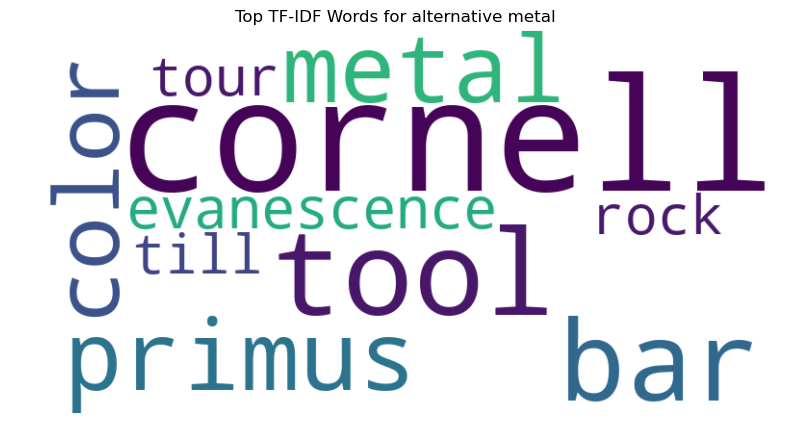

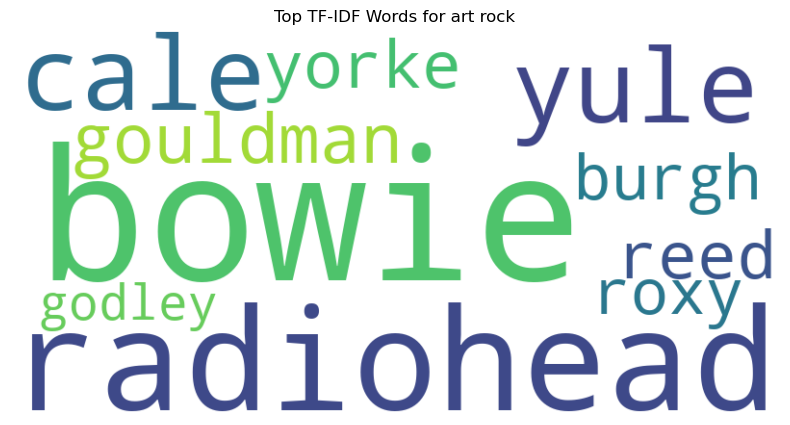

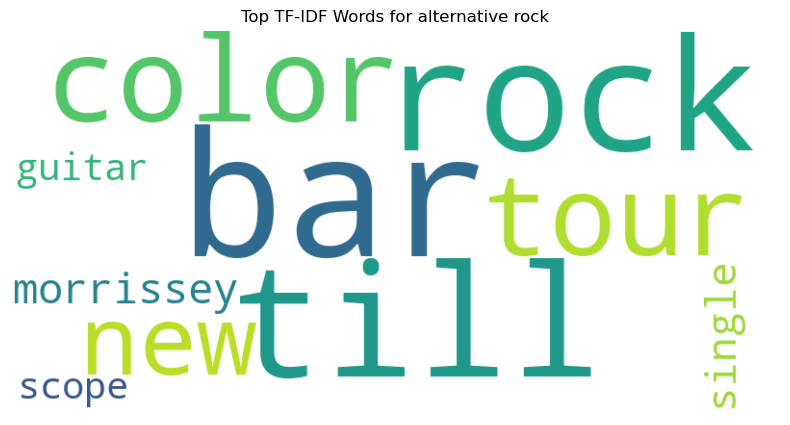

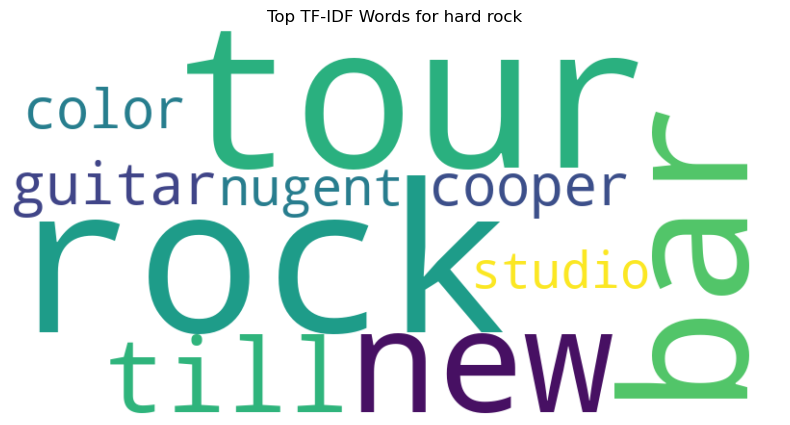

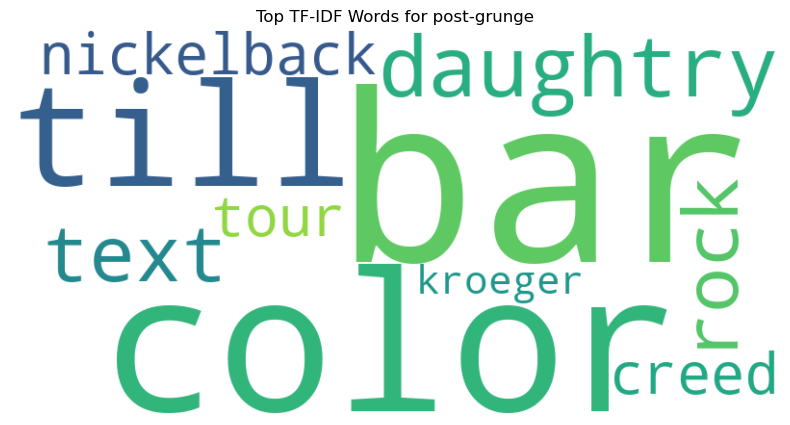

In [32]:
#Load the graph
graph = load_and_clean_graph(PATH_TO_GRAPH)

# Create communities (genre based)
genre_communities = create_genre_partition(graph)

# Process text and divide per genre
aggregated_texts = aggregate_texts_by_genre(genre_communities, PATH_TO_BANDS_FOLDER)

# Perform TF-IDF 
top_terms = perform_tfidf_analysis(aggregated_texts)

# Visualize 
display_top_terms(top_terms, num_genres_to_show=5)
generate_word_clouds(top_terms, num_genres_to_show=5)

## Use the matrix D(Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.


--- Comparing Top Genres to Structural Communities ---
Detected 5 structural communities using Louvain method.
Selected top 5 genres by size: ['rock', 'alternative rock', 'hard rock', 'heavy metal', 'pop rock']

Confusion Matrix 'D' (Top Genres vs. Communities):
                  Comm_0  Comm_1  Comm_2  Comm_3  Comm_4
rock                  11      47       0       1       9
alternative rock       0       1      27      15      18
hard rock             33       2       3       9       1
heavy metal           16       0       0       1       0
pop rock               2       8       0       0       5


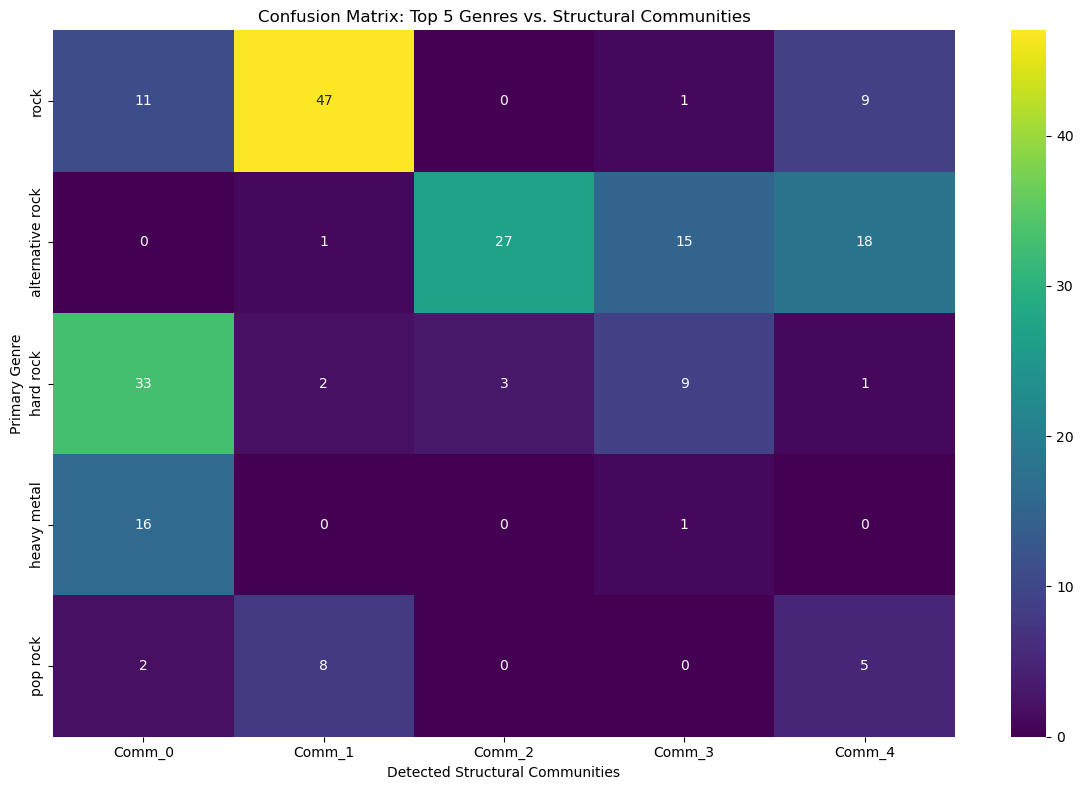

In [35]:
import seaborn as sns

def create_and_visualize_confusion_matrix(graph, genre_communities, top_n=5):
    """
    Detects structural communities, compares them to the largest genre labels,
    and visualizes the result as a confusion matrix heatmap.

    Args:
        graph (nx.Graph): The graph with band nodes.
        genre_communities (dict): A dict mapping genre -> [list of bands].
        top_n (int): Number of largest genres (by number of bands) to include.
    """
    print("\n--- Comparing Top Genres to Structural Communities ---")

    # 1. Detect structural communities using the Louvain method
    structural_communities = list(nx.community.louvain_communities(graph, seed=11))
    print(f"Detected {len(structural_communities)} structural communities using Louvain method.")

    # 2. Choose top N genres by size
    sorted_genres = sorted(genre_communities.items(), key=lambda kv: len(kv[1]), reverse=True)
    top_genres = [genre for genre, bands in sorted_genres[:top_n]]
    print(f"Selected top {len(top_genres)} genres by size: {top_genres}")

    # 3. Create mappings for easier lookup
    node_to_genre = {node: genre for genre, nodes in genre_communities.items() for node in nodes}
    node_to_community = {node: f"Comm_{i}" for i, community_set in enumerate(structural_communities) for node in community_set}

    communities = sorted(list(set(node_to_community.values())), key=lambda x: int(x.split('_')[1]))

    # 4. Build the Confusion Matrix only for top genres
    confusion_matrix = pd.DataFrame(0, index=top_genres, columns=communities)

    for node in graph.nodes():
        genre = node_to_genre.get(node)
        community = node_to_community.get(node)
        if genre in top_genres and community:
            confusion_matrix.loc[genre, community] += 1

    # Filter out empty columns (communities with zero members from the selected genres)
    confusion_matrix = confusion_matrix.loc[:, (confusion_matrix.sum(axis=0) > 0)]

    print("\nConfusion Matrix 'D' (Top Genres vs. Communities):")
    print(confusion_matrix)

    # 5. Visualize the Matrix as a Heatmap
    plt.figure(figsize=(12, 6 + 0.4 * len(top_genres)))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt='g',
        cmap='viridis'
    )
    plt.title(f'Confusion Matrix: Top {len(top_genres)} Genres vs. Structural Communities')
    plt.xlabel('Detected Structural Communities')
    plt.ylabel('Primary Genre')
    plt.tight_layout()
    plt.show()

    return confusion_matrix

# Usage (calls existing variables `graph` and `genre_communities`):
D = create_and_visualize_confusion_matrix(graph, genre_communities, top_n=5)


**Chat** : The analysis reveals a significant divergence between the semantic genre labels and the underlying structural communities of the band network. While our dataset contains 77 distinct primary genres, the Louvain community detection algorithm identifies only 5 major structural communities, indicating that the network is organized around a few large, interconnected scenes."
"For instance, Community 1 represents a vast 'Mainstream Rock' hub, absorbing numerous smaller genres like 'british blues' which, despite being semantically distinct, do not form their own isolated communities. This contrasts with their word-clouds, which may highlight unique lyrical themes, but fails to capture their integration into the broader rock network."
"Furthermore, the 'confusion' for genres like Grunge—which is split primarily between the mainstream, alternative, and metal communities—highlights its role as a bridging genre. The community structure provides evidence of its diverse influences in a way that content-based analysis (like word-clouds) alone cannot."

